# PN2V Prediction
Please run the 'Convallaria-1-CreateNoiseModel' and 'Convallaria-2-Training' notebooks first.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from tifffile import imread
import glob

from unet.model import UNet
from pn2v.utils import denormalize
from pn2v.utils import normalize
from pn2v.utils import PSNR
from pn2v import utils
from pn2v import prediction
import pn2v.training
from pn2v import histNoiseModel


# See if we can use a GPU
device=utils.getDevice()

CUDA available? True


### Load Data

In [11]:
path="/home/krull/fileserver/N2V-SimSim/data/simsim_for_n2v/matslines3d/camsim/orientations/o2/"
files=iles=glob.glob(path+'*sig200*.tif')

data=[]
for f in files:
    data.append(imread(f).astype(np.float32))
    print('loading',f)

data =np.array(data)
print(data.shape)

if len(data.shape)==4:
    data.shape=(data.shape[0]*data.shape[1],data.shape[2],data.shape[3])
dataTest=data


loading /home/krull/fileserver/N2V-SimSim/data/simsim_for_n2v/matslines3d/camsim/orientations/o2/190709-114659_ccd_sig200_exp1_rn8_bgrd0_179_0002_o2.tif
loading /home/krull/fileserver/N2V-SimSim/data/simsim_for_n2v/matslines3d/camsim/orientations/o2/190709-144630_ccd_sig200_exp1_rn8_bgrd0_307_0001_o2.tif
loading /home/krull/fileserver/N2V-SimSim/data/simsim_for_n2v/matslines3d/camsim/orientations/o2/190710-030313_ccd_sig200_exp1_rn8_bgrd0_432_0002_o2.tif
loading /home/krull/fileserver/N2V-SimSim/data/simsim_for_n2v/matslines3d/camsim/orientations/o2/190710-001401_ccd_sig200_exp1_rn8_bgrd0_540_0002_o2.tif
loading /home/krull/fileserver/N2V-SimSim/data/simsim_for_n2v/matslines3d/camsim/orientations/o2/190709-134724_ccd_sig200_exp1_rn8_bgrd0_645_0001_o2.tif
loading /home/krull/fileserver/N2V-SimSim/data/simsim_for_n2v/matslines3d/camsim/orientations/o2/190710-011939_ccd_sig200_exp1_rn8_bgrd0_911_0000_o2.tif
loading /home/krull/fileserver/N2V-SimSim/data/simsim_for_n2v/matslines3d/camsim/o

loading /home/krull/fileserver/N2V-SimSim/data/simsim_for_n2v/matslines3d/camsim/orientations/o2/190709-151726_ccd_sig200_exp1_rn8_bgrd0_720_0001_o2.tif
loading /home/krull/fileserver/N2V-SimSim/data/simsim_for_n2v/matslines3d/camsim/orientations/o2/190710-022859_ccd_sig200_exp1_rn8_bgrd0_111_0003_o2.tif
loading /home/krull/fileserver/N2V-SimSim/data/simsim_for_n2v/matslines3d/camsim/orientations/o2/190709-104623_ccd_sig200_exp1_rn8_bgrd0_194_0003_o2.tif
loading /home/krull/fileserver/N2V-SimSim/data/simsim_for_n2v/matslines3d/camsim/orientations/o2/190709-201434_ccd_sig200_exp1_rn8_bgrd0_489_0002_o2.tif
loading /home/krull/fileserver/N2V-SimSim/data/simsim_for_n2v/matslines3d/camsim/orientations/o2/190709-165324_ccd_sig200_exp1_rn8_bgrd0_116_0000_o2.tif
loading /home/krull/fileserver/N2V-SimSim/data/simsim_for_n2v/matslines3d/camsim/orientations/o2/190709-180305_ccd_sig200_exp1_rn8_bgrd0_621_0000_o2.tif
loading /home/krull/fileserver/N2V-SimSim/data/simsim_for_n2v/matslines3d/camsim/o

loading /home/krull/fileserver/N2V-SimSim/data/simsim_for_n2v/matslines3d/camsim/orientations/o2/190709-101634_ccd_sig200_exp1_rn8_bgrd0_807_0001_o2.tif
loading /home/krull/fileserver/N2V-SimSim/data/simsim_for_n2v/matslines3d/camsim/orientations/o2/190710-004554_ccd_sig200_exp1_rn8_bgrd0_456_0002_o2.tif
loading /home/krull/fileserver/N2V-SimSim/data/simsim_for_n2v/matslines3d/camsim/orientations/o2/190709-185950_ccd_sig200_exp1_rn8_bgrd0_311_0003_o2.tif
loading /home/krull/fileserver/N2V-SimSim/data/simsim_for_n2v/matslines3d/camsim/orientations/o2/190709-154918_ccd_sig200_exp1_rn8_bgrd0_347_0002_o2.tif
loading /home/krull/fileserver/N2V-SimSim/data/simsim_for_n2v/matslines3d/camsim/orientations/o2/190709-121646_ccd_sig200_exp1_rn8_bgrd0_159_0001_o2.tif
loading /home/krull/fileserver/N2V-SimSim/data/simsim_for_n2v/matslines3d/camsim/orientations/o2/190709-101634_ccd_sig200_exp1_rn8_bgrd0_807_0003_o2.tif
(116, 75, 128, 128)


### Load the Network and Noise Model

In [4]:
# We are loading the histogram from the 'Convallaria-1-CreateNoiseModel' notebook.
histogram=np.load(path+'../../noiseModel.npy')

# Create a NoiseModel object from the histogram.
noiseModel=histNoiseModel.NoiseModel(histogram, device=device)

In [5]:
# Load the network, created in the 'Convallaria-2-Training' notebook
net=torch.load(path+"/last_conv.net")

### Evaluation

In [12]:
# Now we are processing data and calculating PSNR values.
results=[]
meanRes=[]
resultImgs=[]
inputImgs=[]

# We iterate over all test images.
for index in range(50):
    
    im=dataTest[index]
  #  gt=dataTestGT[0] # The ground truth is the same for all images
    
    # We are using tiling to fit the image into memory
    # If you get an error try a smaller patch size (ps)
    means, mseEst = prediction.tiledPredict(im, net ,ps=128, overlap=48,
                                            device=device, noiseModel=noiseModel)
    
    resultImgs.append(mseEst)
    meanRes.append(means)
    inputImgs.append(im)

   # rangePSNR=np.max(gt)-np.min(gt)
   # psnr=PSNR(gt, mseEst,rangePSNR )
   # psnrPrior=PSNR(gt, means,rangePSNR )
   # results.append(psnr)
   # meanRes.append(psnrPrior)

    print ("image:",index, dataTest.shape[0])
   # print ("PSNR input",PSNR(gt, im, rangePSNR))
   # print ("PSNR prior",psnrPrior) # Without info from masked pixel
   # print ("PSNR mse",psnr) # MMSE estimate using the masked pixel
   # print ('-----------------------------------')

    
    
    


#print("Avg PSNR Prior:", np.mean(np.array(meanRes) ), '+-(2SEM)',2*np.std(np.array(meanRes) )/np.sqrt(float(len(meanRes)) ) )
#print("Avg PSNR MMSE:", np.mean(np.array(results) ),  '+-(2SEM)' ,2*np.std(np.array(results) )/np.sqrt(float(len(results)) ) )

image: 0 8700
image: 1 8700
image: 2 8700
image: 3 8700
image: 4 8700
image: 5 8700
image: 6 8700
image: 7 8700
image: 8 8700
image: 9 8700
image: 10 8700
image: 11 8700
image: 12 8700
image: 13 8700
image: 14 8700
image: 15 8700
image: 16 8700
image: 17 8700
image: 18 8700
image: 19 8700
image: 20 8700
image: 21 8700
image: 22 8700
image: 23 8700
image: 24 8700
image: 25 8700
image: 26 8700
image: 27 8700
image: 28 8700
image: 29 8700
image: 30 8700
image: 31 8700
image: 32 8700
image: 33 8700
image: 34 8700
image: 35 8700
image: 36 8700
image: 37 8700
image: 38 8700
image: 39 8700
image: 40 8700
image: 41 8700
image: 42 8700
image: 43 8700
image: 44 8700
image: 45 8700
image: 46 8700
image: 47 8700
image: 48 8700
image: 49 8700


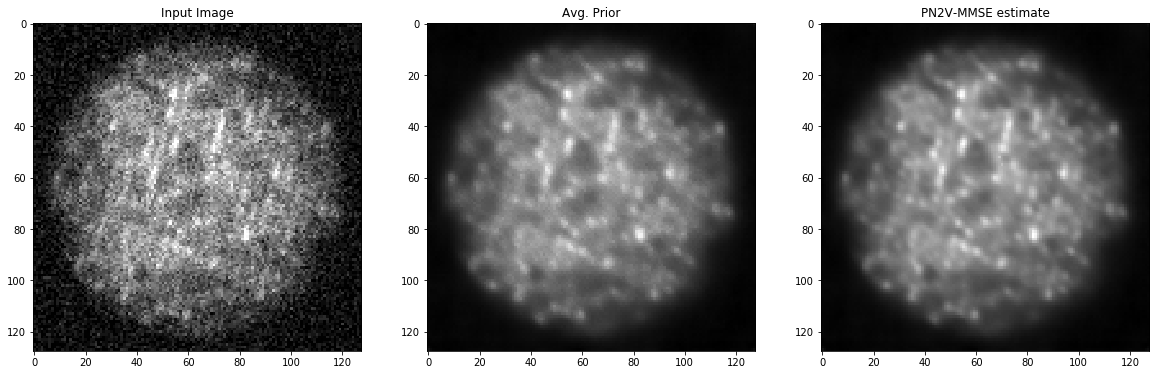

In [14]:
index=32

im=inputImgs[index]
means=meanRes[index]
mseEst=resultImgs[index]

vmi=np.percentile(mseEst,0.01)
vma=np.percentile(mseEst,99.99)

plt.figure(figsize=(20, 20))
plt.subplot(1, 3, 1)
plt.title(label='Input Image')
plt.imshow(im, vmax=vma, vmin=vmi, cmap='gray')

plt.subplot(1, 3, 2)
plt.title(label='Avg. Prior')
plt.imshow(means, vmax=vma, vmin=vmi, cmap='gray')

plt.subplot(1, 3, 3)
plt.title(label='PN2V-MMSE estimate')
plt.imshow(mseEst, vmax=vma, vmin=vmi, cmap='gray')
plt.show()

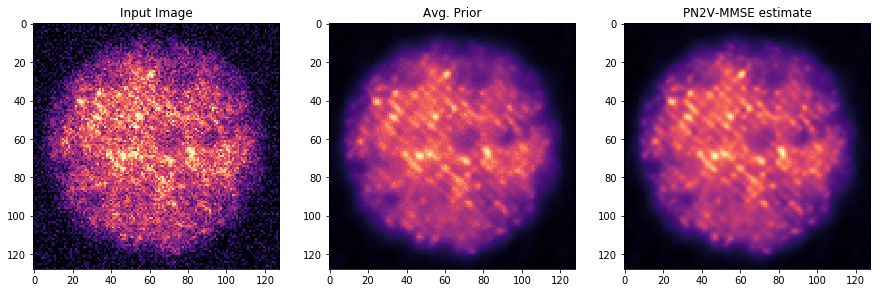

In [10]:
index=100

im=inputImgs[index]
means=meanRes[index]
mseEst=resultImgs[index]

vmi=np.percentile(mseEst,0.01)
vma=np.percentile(mseEst,99.99)

plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.title(label='Input Image')
plt.imshow(im, vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 3, 2)
plt.title(label='Avg. Prior')
plt.imshow(means, vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 3, 3)
plt.title(label='PN2V-MMSE estimate')
plt.imshow(mseEst, vmax=vma, vmin=vmi, cmap='magma')
plt.show()